# **EE 344 HW 2 - Aarav Wadhwani**

## Setup

### 1) Imports

In [31]:
# ============================================================
# Imports
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### 2) Helper functions
We use a few helper functions for:  
- fitting OLS models (with intercept)  
- computing Cook’s Distance and leverage  
- plotting regression lines/curves  


In [32]:
def fit_ols_diagnostics(X, y):
    """Fit OLS and return (model, diagnostics dataframe).

    Parameters
    ----------
    X : array-like, shape (n,) or (n, p)
        Feature matrix (without intercept column).
    y : array-like, shape (n,)
        Target vector.
    """
    X = np.asarray(X)
    y = np.asarray(y).reshape(-1)
    if X.ndim == 1:
        X = X.reshape(-1, 1)

    # Add intercept column for statsmodels
    X_sm = sm.add_constant(X)
    model = sm.OLS(y, X_sm).fit()

    infl = OLSInfluence(model)
    diag = pd.DataFrame({
        "y": y,
        "y_hat": model.fittedvalues,
        "residual": model.resid,
        "leverage_hii": infl.hat_matrix_diag,   # diagonal of Hat matrix H
        "cooks_D": infl.cooks_distance[0]
    })
    return model, diag


def eval_metrics(y_true, y_pred):
    return {
        "mse": mean_squared_error(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred),
        "r2":  r2_score(y_true, y_pred),
    }

### 4) Load & Check Dataset

In [33]:
# ============================================================
# Load dataset
# ============================================================

DATA_PATH = "usina_with_outliers.csv"
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
print("\nColumns:")
print(df.columns.tolist())

display(df.head())

print("\nSummary statistics:")
display(df.describe(include="all"))

print("\nMissing values per column:")
display(df.isna().sum())

Shape: (9568, 5)

Columns:
['AT', 'V', 'AP', 'RH', 'PE']


,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90



Summary statistics:


,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.618518,54.250021,1013.288871,73.308978,454.407820
std,8.256412,13.993655,6.636609,16.094499,18.760047
min,-39.174839,-38.397358,959.607298,-53.091613,327.528030
25%,13.480000,41.670000,1009.077500,63.227500,439.730000
50%,20.320000,52.080000,1012.950000,74.955000,451.620000
75%,25.732500,66.540000,1017.320000,84.882500,468.530000
max,77.344839,155.117358,1064.772702,187.691613,590.091970



Missing values per column:


,0
AT,0
V,0
AP,0
RH,0
PE,0


## Q1) utlier Detection and Removal using Cook’s Distance

#### Q1.1)

- **Model:** OLS Linear Regression, because Cook’s Distance is derived for OLS influence diagnostics; regularization changes the estimator and complicates classical Cook’s D interpretation.

- **Library:** statsmodels, because it provides built-in influence measures (hat matrix diagonal, Cook’s D) in a transparent, reproducible workflow; scikit-learn would require re-deriving/implementing influence metrics manually.


#### Q1.2)

In [34]:
## IVs and DV
feature_cols = ["AT", "V", "AP", "RH"]
target_col = "PE"

X = df[feature_cols]
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42
)

model_full, diag_full = fit_ols_diagnostics(X, y)

print(model_full.summary())

### Cook’s Distance threshold
n = len(X)
threshold = 4 / n

diag_table = diag_full.copy()
diag_table["flag_D_gt_4_over_n"] = diag_table["cooks_D"] > threshold

print(f"Cook's distance heuristic threshold 4/n = {threshold:.6f}")
print(f"Number of flagged outliers = {diag_table['flag_D_gt_4_over_n'].sum()}")

# Remove ALL flagged outliers
keep_mask = ~diag_table["flag_D_gt_4_over_n"].values

X_clean = X.iloc[keep_mask].copy()
y_clean = y.iloc[keep_mask].copy()

model_clean, diag_clean = fit_ols_diagnostics(X_clean, y_clean)

df_clean = pd.concat([X_clean, y_clean], axis=1)
df_clean.to_csv("usina.csv", index=False)

print("Exported cleaned dataset to usina.csv")

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     4416.
Date:                Tue, 27 Jan 2026   Prob (F-statistic):               0.00
Time:                        07:49:59   Log-Likelihood:                -36621.
No. Observations:                9568   AIC:                         7.325e+04
Df Residuals:                    9563   BIC:                         7.329e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         47.7845     19.524      2.447      0.0

## Q2) rain/Test Evaluation Before vs After Outlier Removal

In [35]:
def fit_and_report_q2(df, dataset_name):
    feature_cols = ["AT", "V", "AP", "RH"]
    target_col = "PE"

    X = df[feature_cols]
    y = df[target_col]

    # Required split for Q2
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, random_state=42
    )

    lambdas = [0.01, 0.1, 1, 10, 100]

    rows = []

    # ----- Linear Regression -----
    lin = LinearRegression()
    lin.fit(X_train, y_train)

    for split, Xt, yt in [
        ("train", X_train, y_train),
        ("test", X_test, y_test),
    ]:
        preds = lin.predict(Xt)
        metrics = eval_metrics(yt, preds)
        rows.append({
            "dataset": dataset_name,
            "model": "Linear",
            "lambda": None,
            "split": split,
            **metrics,
        })

    # ----- Ridge & Lasso -----
    for alpha in lambdas:
        for name, Model in [("Ridge", Ridge), ("Lasso", Lasso)]:
            model = Model(alpha=alpha, max_iter=50000, random_state=42)
            model.fit(X_train, y_train)

            for split, Xt, yt in [
                ("train", X_train, y_train),
                ("test", X_test, y_test),
            ]:
                preds = model.predict(Xt)
                metrics = eval_metrics(yt, preds)
                rows.append({
                    "dataset": dataset_name,
                    "model": name,
                    "lambda": alpha,
                    "split": split,
                    **metrics,
                })

    return pd.DataFrame(rows)

In [36]:
# Dataset WITH outliers
df_outliers = pd.read_csv("usina_with_outliers.csv")
results_outliers = fit_and_report_q2(df_outliers, "with_outliers")

# Dataset WITHOUT outliers
df_clean = pd.read_csv("usina.csv")
results_clean = fit_and_report_q2(df_clean, "without_outliers")

# Combine for easy comparison
q2_results = pd.concat([results_outliers, results_clean], axis=0)

display(
    q2_results
    .sort_values(["dataset", "model", "lambda", "split"])
)

,dataset,model,lambda,split,mse,mae,r2
5,with_outliers,Lasso,0.01,test,125.115332,5.052626,0.642568
4,with_outliers,Lasso,0.01,train,123.384210,5.198858,0.650171
9,with_outliers,Lasso,0.10,test,125.134495,5.055348,0.642514
8,with_outliers,Lasso,0.10,train,123.384607,5.201739,0.650169
13,with_outliers,Lasso,1.00,test,125.338356,5.083092,0.641931
12,with_outliers,Lasso,1.00,train,123.421151,5.229507,0.650066
17,with_outliers,Lasso,10.00,test,128.902136,5.408803,0.631750
16,with_outliers,Lasso,10.00,train,126.141514,5.540418,0.642353
21,with_outliers,Lasso,100.00,test,233.064336,11.258653,0.334178
20,with_outliers,Lasso,100.00,train,234.655937,11.285489,0.334683


### Discussion

- **Effect of outliers on train vs. test performance:** The presence of outliers substantially degrades both training and test performance. With outliers, test MSE is approximately 125 and test R2 is around 0.64, whereas after outlier removal, test MSE drops to about 20 and test R2 increases to approximately 0.93. Similar improvements are observed in MAE. This indicates that the influential outliers distort the fitted linear relationship, increasing error on both seen and unseen data rather than only causing overfitting.

- **Generalization: with outliers vs. without outliers:** The dataset without outliers (usina.csv) clearly shows better generalization. Not only are test errors much lower, but the train–test gap remains small and stable, suggesting the underlying linear model captures the true signal more effectively once influential points are removed. In contrast, the dataset with outliers exhibits consistently higher error and lower R2 on both splits, indicating reduced model reliability.



- **Impact of Ridge and Lasso relative to Linear Regression:** For both datasets, Ridge regression performs almost identically to standard linear regression across all λ values, indicating that coefficient shrinkage does not materially change the solution. Lasso behaves similarly for small λ, but for large λ (e.g., 10 and 100), performance degrades significantly, with sharp increases in MSE and large drops in R2. This suggests that excessive regularization leads to underfitting. Overall, once outliers are removed, regularization provides little benefit, and plain linear regression already generalizes well.

## Q3) Reliability of Coefficients

#### Q3.1)

For this coefficient-reliability analysis, I use ordinary least squares (linear regression) implemented with statsmodels OLS. Linear regression is appropriate because the goal is not predictive performance but inference about coefficients, and OLS provides well-defined measures of reliability such as t-statistics and p-values.

Statsmodels is chosen over scikit-learn because it directly exposes these inference diagnostics, whereas scikit-learn focuses on prediction and does not provide statistical significance measures.

I do not scale the independent variables or the target for this task, since scaling changes coefficient units and complicates interpretability. Instead, coefficients are estimated in the original data scale, and standardized coefficients are computed afterward using training-set statistics to compare effect sizes across features without altering the underlying inference.

In [37]:
def standardized_coef_unscaled(beta, X_train_raw, y_train_raw):
    """Standardized coefficients (effect size) for unscaled data."""
    std_x = np.std(X_train_raw, axis=0, ddof=0)
    std_y = float(np.std(y_train_raw, axis=0, ddof=0))
    std_y = std_y if std_y > 0 else 1.0
    return beta * (std_x / std_y)

df = pd.read_csv("usina.csv")

feature_names = ["AT", "V", "AP", "RH"]
target_name = "PE"

X = df[feature_names].values
y = df[target_name].values.reshape(-1, 1)

X_train_un, X_test_un, y_train_un, y_test_un = train_test_split(
    X, y, test_size=0.30, random_state=42
)

# Same as linear_with_ols_reports from demo, but only for unscaled data
# Fit Linear Regression (sklearn, for coef extraction)
lr = LinearRegression()
lr.fit(X_train_un, y_train_un.ravel())

pred_tr = lr.predict(X_train_un).reshape(-1,1)
pred_te = lr.predict(X_test_un).reshape(-1,1)

train_metrics = eval_metrics(y_train_un, pred_tr)
test_metrics  = eval_metrics(y_test_un, pred_te)

print("Train metrics:", train_metrics)
print("Test metrics:", test_metrics)

X_sm = sm.add_constant(X_train_un)
ols = sm.OLS(y_train_un, X_sm).fit()

ols_table = pd.DataFrame({
    "term": ["const"] + feature_names,
    "beta_hat": ols.params.reshape(-1),
    "t_value": ols.tvalues.reshape(-1),
    "p_value": ols.pvalues.reshape(-1),
}).sort_values("t_value", key=np.abs, ascending=False)

display(ols_table)



Train metrics: {'mse': 19.864671003981226, 'mae': 3.5963964217310505, 'r2': 0.9313692265834657}
Test metrics: {'mse': 20.396772456043262, 'mae': 3.6247726076133886, 'r2': 0.9303022187088379}


,term,beta_hat,t_value,p_value
1,AT,-1.966193,-108.971834,0.000000e+00
0,const,443.753358,38.455715,3.717392e-292
4,RH,-0.150944,-31.237663,6.360165e-200
2,V,-0.234557,-27.390969,1.487453e-156
3,AP,0.072105,6.438038,1.295207e-10


In [38]:
beta = lr.coef_.reshape(-1)
beta_std = standardized_coef_unscaled(beta, X_train_un, y_train_un)

coef_table = pd.DataFrame({
    "feature": feature_names,
    "coef_value": beta,
    "standardized_coef": beta_std
}).sort_values("standardized_coef", key=np.abs, ascending=False)

display(coef_table)


/tmp/ipython-input-2934752084.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  std_y = float(np.std(y_train_raw, axis=0, ddof=0))


,feature,coef_value,standardized_coef
0,AT,-1.966193,-0.860352
1,V,-0.234557,-0.175103
3,RH,-0.150944,-0.131132
2,AP,0.072105,0.025179


- **The coefficient on AT is the most reliable:**
  - largest |t| = 108.97
  - smallest p = 0
  - largest |standardized_coef| = 0.860


- **The coefficient on AP is the least reliable:**
  - smallest |t| = 6.44
  - largest p = 1.3e-10
  - smallest |standardized_coef| = 0.025

## Q4) Most Important vs Least Important Features
#### Q4.1)
For feature importance, I use linear regression with scikit-learn and assess importance via standardized coefficients. Linear regression is appropriate because feature importance is directly reflected by coefficient magnitude once features are placed on a common scale. I do not refit a scaled model; instead, I compute standardized coefficients post-hoc using training-set statistics. This ensures that differences in feature units do not distort importance comparisons, while preserving the original fitted model.

#### Q4.2)

Most important feature: **AT (Ambient Temperature)**
  - Largest absolute standardized coefficient: |−0.860|
  - Indicates the largest effect on PE per one standard deviation change

Least important feature: **AP (Ambient Pressure)**
  - Smallest absolute standardized coefficient: |0.025|
  - Indicates minimal contribution relative to other features

## Q5)



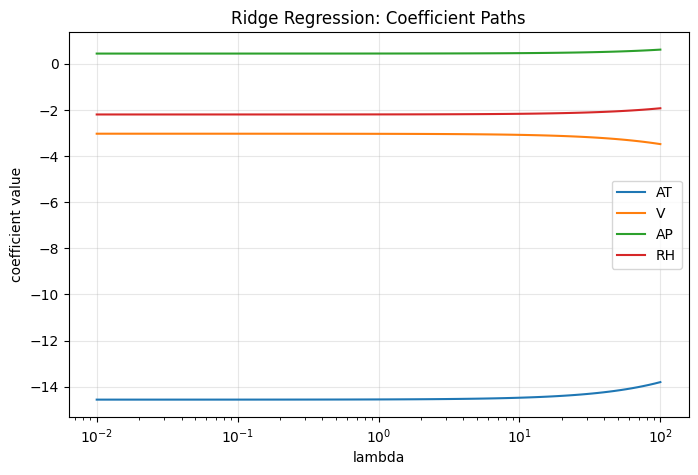

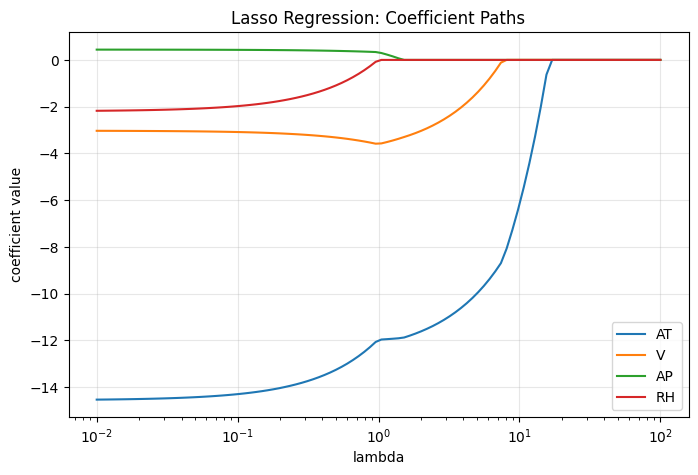

In [39]:
x_scaler = StandardScaler()
X_scaled = x_scaler.fit_transform(X)

lambda_grid = np.logspace(-2, 2, 100)

ridge_coefs = []

for lam in lambda_grid:
    model = Ridge(alpha=lam, random_state=42)
    model.fit(X_scaled, y)
    ridge_coefs.append(model.coef_)

ridge_coefs = np.array(ridge_coefs)


lasso_coefs = []

for lam in lambda_grid:
    model = Lasso(alpha=lam, max_iter=50000, random_state=42)
    model.fit(X_scaled, y)
    lasso_coefs.append(model.coef_)

lasso_coefs = np.array(lasso_coefs)


plt.figure(figsize=(8, 5))
for i, name in enumerate(feature_names):
    plt.plot(lambda_grid, ridge_coefs[:, i], label=name)

plt.xscale("log")
plt.xlabel("lambda")
plt.ylabel("coefficient value")
plt.title("Ridge Regression: Coefficient Paths")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


plt.figure(figsize=(8, 5))
for i, name in enumerate(feature_names):
    plt.plot(lambda_grid, lasso_coefs[:, i], label=name)

plt.xscale("log")
plt.xlabel("lambda")
plt.ylabel("coefficient value")
plt.title("Lasso Regression: Coefficient Paths")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


### Discussion

- **Effect of increasing λ in Ridge vs Lasso:**
  
  As λ increases, Ridge regression slowly shrinks all coefficients toward zero, but none of them become exactly zero. In our plots, this shrinkage is fairly small, which suggests the original linear model is already stable. Lasso regression behaves differently: as λ increases, some coefficients are driven exactly to zero, meaning certain features are completely removed from the model.

- **Multicollinearity:**

  Ridge regression works better when the independent variables are correlated because it shrinks all coefficients together instead of dropping any one feature. This makes the model more stable when there is multicollinearity. Lasso can be less stable in this case because it often keeps one correlated feature and sets the others to zero.

- **Feature selection:**

  Lasso regression is better for feature selection since it can set coefficients exactly to zero as λ increases, effectively choosing a smaller set of important features. Ridge regression does not perform feature selection because it only shrinks coefficients but keeps all features in the model (non zero coefficients).